# IPL Score Prediction using Deep Learning

In the fast-paced world of IPL, where every run and decision can change the outcome of a match, predicting scores in real time has become both exciting and valuable. Deep learning, with its ability to process massive amounts of historical and live match data, is revolutionizing the way fans, analysts and even teams anticipate results. By uncovering complex patterns that humans or traditional methods might miss, deep learning offers highly accurate score forecasts, making it a powerful tool for enhancing the thrill and strategy of the game.

## 1. Installing Libraries

We are importing all necessary Python libraries such as NumPy, Pandas, Scikit-learn, Matplotlib, Keras and Seaborn required for data handling, visualization, preprocessing and building deep learning models.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras 
import tensorflow as tf

## 2. Loading the Dataset

The dataset contains data from 2008 to 2017 and contains features like venue, date, batting and bowling team, names of batsman and bowler, wickets and more. We will load the IPL cricket data from CSV files into pandas DataFrames to explore and prepare for modeling.

In [17]:
ipl = pd.read_csv('ipl_data.csv')
ipl.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


## 3. Exploratory Data Analysis

We will do Exploratory Data Analysis (EDA) to analyze how many unique matches have been played at each venue by counting distinct match IDs for every venue. Then, we’ll visualize this data using a horizontal bar chart to see which venues host the most matches.

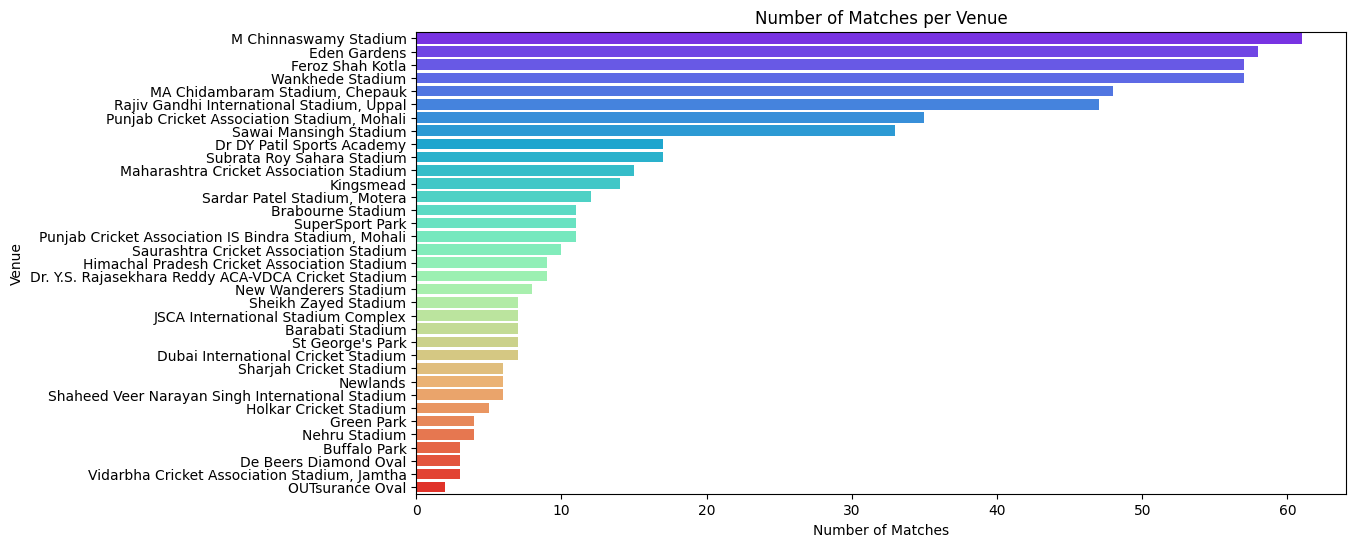

In [18]:
data = ipl.copy()
matches_per_venue = data[['mid', 'venue']].drop_duplicates()
matches_count = matches_per_venue['venue'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=matches_count.values, y=matches_count.index, palette="rainbow")
plt.title('Number of Matches per Venue')
plt.xlabel('Number of Matches')
plt.ylabel('Venue')
plt.show()

Next we will calculate the maximum runs scored by each batsman by grouping the data by batsman their runs. Then we’ll identify the top 10 batsmen with the highest runs and display this information using a horizontal bar chart.

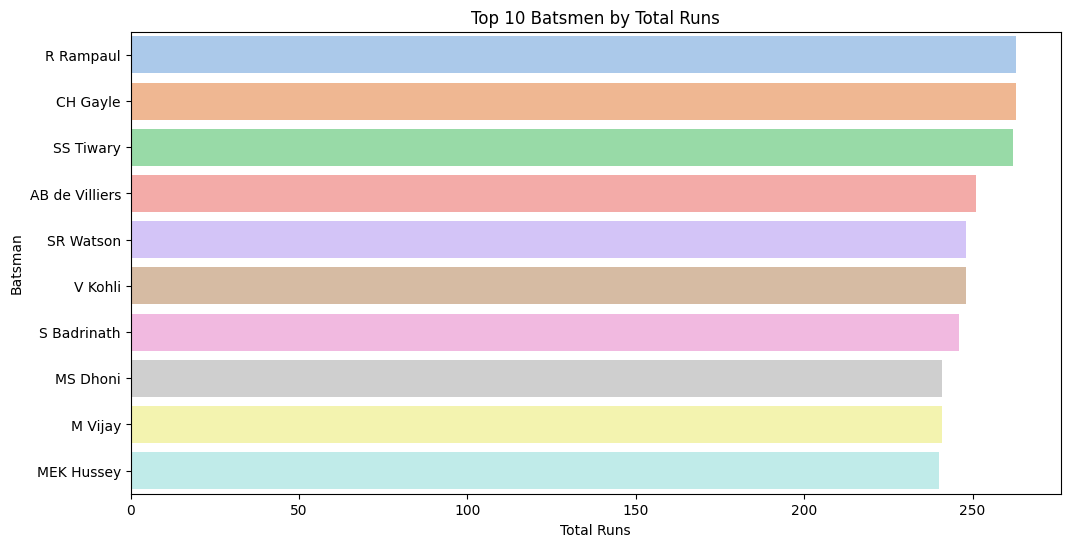

In [19]:
runs_by_batsman = data.groupby('batsman')['runs'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=runs_by_batsman.values, y=runs_by_batsman.index,palette="pastel")
plt.title('Top 10 Batsmen by Total Runs')
plt.xlabel('Total Runs')
plt.ylabel('Batsman')
plt.show()

After that we can do the same for the bowlers, in terms of total wickets.

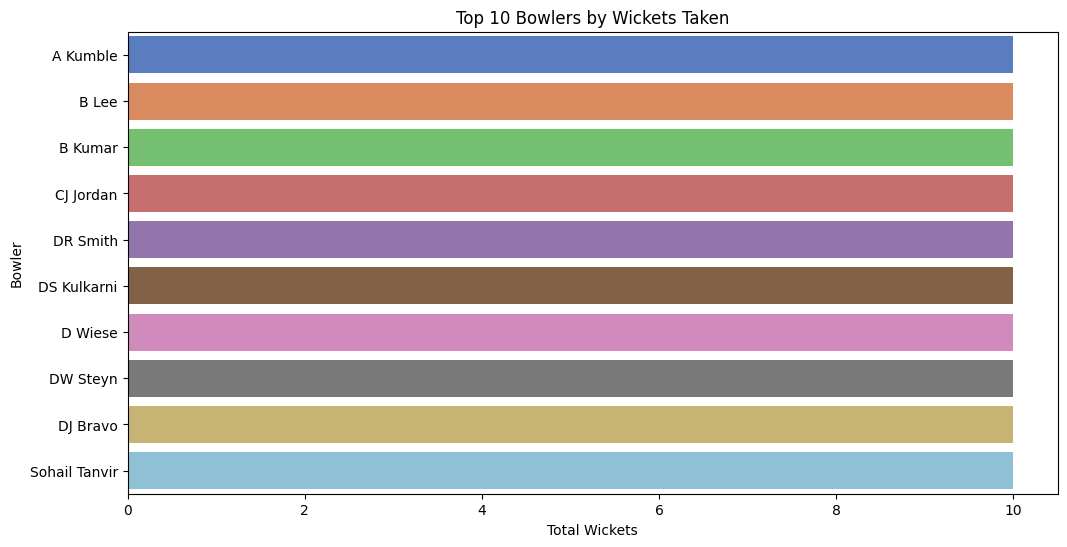

In [20]:
wickets_by_bowler = data.groupby(
    'bowler')['wickets'].max().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=wickets_by_bowler.values,
            y=wickets_by_bowler.index, palette="muted")
plt.title('Top 10 Bowlers by Wickets Taken')
plt.xlabel('Total Wickets')
plt.ylabel('Bowler')
plt.show()

## 4. Performing Label Encoding

We will convert categorical text data into numeric labels using Label Encoding because ML models work with numbers.

* LabelEncoder() converts text labels into integers.
* fit_transform() learns encoding and applies it.
* copy() : creates a duplicate of the DataFrame to avoid changing the original data

A dictionary assignment stores each encoder for future use like decoding or consistent transformation

In [21]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['bat_team', 'bowl_team', 'venue', "batsman", "bowler"]

data_encoded = data.copy()

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = le

## 5. Performing Feature Selection

We drop date and mid columns because they are identifiers and don’t provide meaningful information for correlation analysis. By removing these irrelevant columns we focus on features that can reveal relationships useful for modeling or insights. Computing and visualizing correlations helps identify which features are related and can guide feature selection.

* drop() : removes specified columns from the DataFrame
* corr() : computes pairwise correlations between numerical features
* sns.heatmap() : creates a colored matrix to visualize correlations with values
* plt.show() : displays the plot on screen

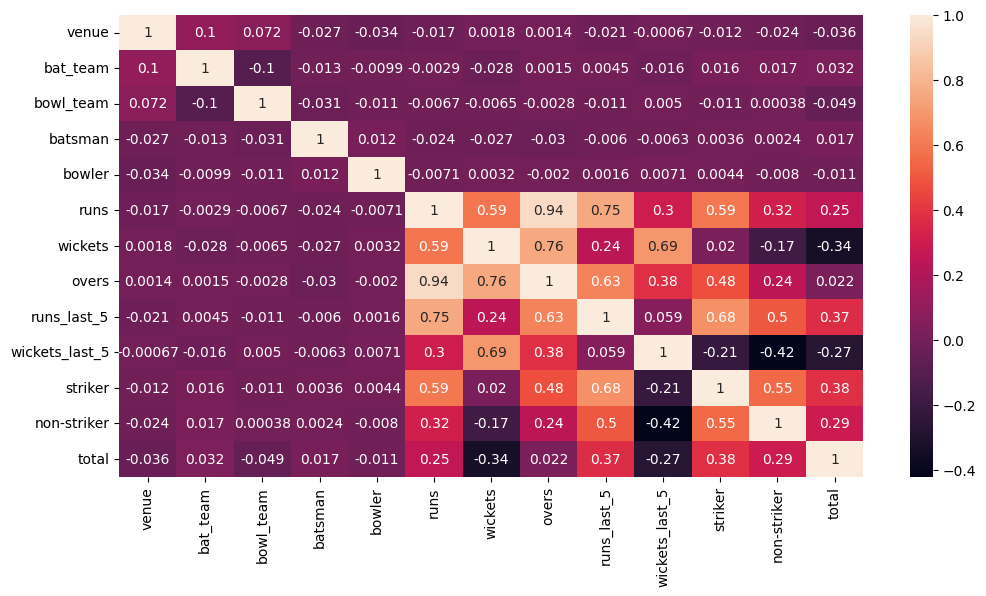

In [22]:
data_corr = data_encoded.drop(columns=["date", "mid"], axis=1)
plt.figure(figsize=(12, 6))
sns.heatmap(data_corr.corr(), annot=True)
plt.show()

Based on the heatmap we will drop the columns runs_last_5, wickets_last_5 and non-striker because they show high correlation with other features. Dropping highly correlated columns helps reduce redundancy and prevents multicollinearity which can improve model performance and interpretability.

## 6. Splitting the Dataset into Training and Testing

We will select relevant features and the target variable then split the data into training and testing sets for model building and evaluation.

* DataFrame indexing (data_encoded[feature_cols]) : selects specified columns as features
* train_test_split() : splits features and target into training and test subsets
* test_size=0.3 : assigns 30% of data for testing
* random_state=42 : ensures reproducible splits by fixing the random seed

In [23]:
from sklearn.model_selection import train_test_split
feature_cols = ['bat_team', 'bowl_team', 'venue', 'runs',
                'wickets', 'overs', 'striker', 'batsman', 'bowler']

X = data_encoded[feature_cols]
y = data_encoded['total']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

## 7. Performing Feature Scaling

We will perform Min-Max scaling on our input features to ensure all the features are on the same scale. It ensures consistent scale and improves model performance. Scaling will be done on both training and testing data using the scaling parameters.

* MinMaxScaler() scales features to [0,1] range.
* fit_transform() fits scaler on training data and transforms it.
* transform() applies same scaler to test data.

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 8. Building the Neural Network

We will build neural network using TensorFlow and Keras for regression. After building the model we have compiled the model using the Huber Loss because of the robustness of the regression against outliers.

* keras.Sequential() creates a stack of layers.
* Dense layers are fully connected layers.
* activation=relu adds non-linearity.
* Output layer uses linear activation because it’s regression.
* Huber loss combines MSE and MAE advantages to handle outliers better.
* adam optimizer adjusts weights efficiently.

In [25]:
model = keras.Sequential([
    keras.layers.Input( shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dense(216, activation='relu'),  
    keras.layers.Dense(1, activation='linear') 
])

huber_loss = tf.keras.losses.Huber(delta=1.0)  # You can adjust the 'delta' parameter as needed
model.compile(optimizer='adam', loss=huber_loss)

## 9. Training the Model

We train the model on the scaled training data for 10 epochs with a batch size of 64, validating on the test set.

* model.fit() trains the model.
* epochs=10 means the model sees the whole data 10 times.
* batch_size=64 updates weights after every 64 samples.
* validation_data evaluates model on test set during training.

In [26]:
model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test))

Epoch 1/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 26.4162 - val_loss: 15.3096
Epoch 2/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.8713 - val_loss: 14.2822
Epoch 3/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.7443 - val_loss: 14.3051
Epoch 4/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.6598 - val_loss: 14.3807
Epoch 5/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.6298 - val_loss: 14.5112
Epoch 6/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.6146 - val_loss: 14.5148
Epoch 7/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.5922 - val_loss: 14.2657
Epoch 8/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.5994 - val_loss: 14.5589
Epoch 9/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.5877 - val_loss: 14.3960
Epoch 10/10
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 14.5485 - val_loss: 14.1596


We can plot the loss and validation loss of the model.

<Axes: >

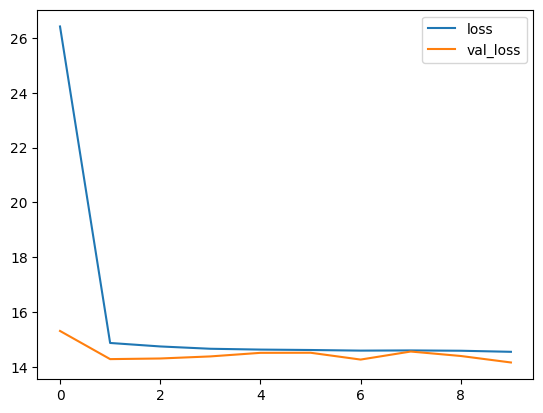

In [27]:
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

## 10. Evaluating the Model

We predict scores on test data and evaluate model performance using mean absolute error (MAE).

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(X_test_scaled)

mean_absolute_error(y_test, predictions)

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


14.651204109191895

## 11. Creating an Interactive Widget for Score Prediction

We build an interactive interface using ipywidgets so users can select match details and get a live predicted score.

* **widgets.Dropdown()** creates dropdown menus.
* **widgets.Button()** creates a clickable button.
* **predict_score()** function handles user inputs, encodes and scales them, runs prediction and displays result.
* **display()** shows widgets in the notebook.

In [29]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

venue = widgets.Dropdown(options=list(
    label_encoders['venue'].classes_), description='Select Venue:')
venue.style = {'description_width': 'initial'}

batting_team = widgets.Dropdown(options=list(
    label_encoders['bat_team'].classes_), description='Select Batting Team:')
batting_team.style = {'description_width': 'initial'}

bowling_team = widgets.Dropdown(options=list(
    label_encoders['bowl_team'].classes_), description='Select Bowling Team:')
bowling_team.style = {'description_width': 'initial'}

striker = widgets.Dropdown(options=list(
    label_encoders['batsman'].classes_), description='Select Striker:')
striker.style = {'description_width': 'initial'}

bowler = widgets.Dropdown(options=list(
    label_encoders['bowler'].classes_), description='Select Bowler:')
bowler.style = {'description_width': 'initial'}

runs = widgets.IntText(value=0, description='Runs:', style={
                       'description_width': 'initial'})
wickets = widgets.IntText(value=0, description='Wickets:', style={
                          'description_width': 'initial'})
overs = widgets.FloatText(value=0.0, description='Overs:', style={
                          'description_width': 'initial'})
striker_ind = widgets.IntText(value=0, description='Striker:', style={
                              'description_width': 'initial'})  # Assuming 0 or 1
predict_button = widgets.Button(description="Predict Score")

output = widgets.Output()


def predict_score(b):
    with output:
        clear_output()  # Clear previous output

        encoded_venue = label_encoders['venue'].transform([venue.value])[0]
        encoded_batting_team = label_encoders['bat_team'].transform(
            [batting_team.value])[0]
        encoded_bowling_team = label_encoders['bowl_team'].transform(
            [bowling_team.value])[0]
        encoded_striker = label_encoders['batsman'].transform([striker.value])[
            0]
        encoded_bowler = label_encoders['bowler'].transform([bowler.value])[0]

        input_features = [
            encoded_batting_team,
            encoded_bowling_team,
            encoded_venue,
            runs.value,
            wickets.value,
            overs.value,
            striker_ind.value,
            encoded_striker,
            encoded_bowler
        ]

        input_array = np.array(input_features).reshape(1, -1)
        input_array = scaler.transform(input_array)
        predicted_score = model.predict(input_array)

        print(f"Predicted Total Runs: {int(predicted_score[0])}")


predict_button.on_click(predict_score)

display(venue, batting_team, bowling_team, striker, bowler,
        runs, wickets, overs,
        striker_ind,
        predict_button, output)

Dropdown(description='Select Venue:', options=('Barabati Stadium', 'Brabourne Stadium', 'Buffalo Park', 'De Be…

Dropdown(description='Select Batting Team:', options=('Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredev…

Dropdown(description='Select Bowling Team:', options=('Chennai Super Kings', 'Deccan Chargers', 'Delhi Daredev…

Dropdown(description='Select Striker:', options=('A Ashish Reddy', 'A Chandila', 'A Chopra', 'A Choudhary', 'A…

Dropdown(description='Select Bowler:', options=('A Ashish Reddy', 'A Chandila', 'A Choudhary', 'A Flintoff', '…

IntText(value=0, description='Runs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Wickets:', style=DescriptionStyle(description_width='initial'))

FloatText(value=0.0, description='Overs:', style=DescriptionStyle(description_width='initial'))

IntText(value=0, description='Striker:', style=DescriptionStyle(description_width='initial'))

Button(description='Predict Score', style=ButtonStyle())

Output()

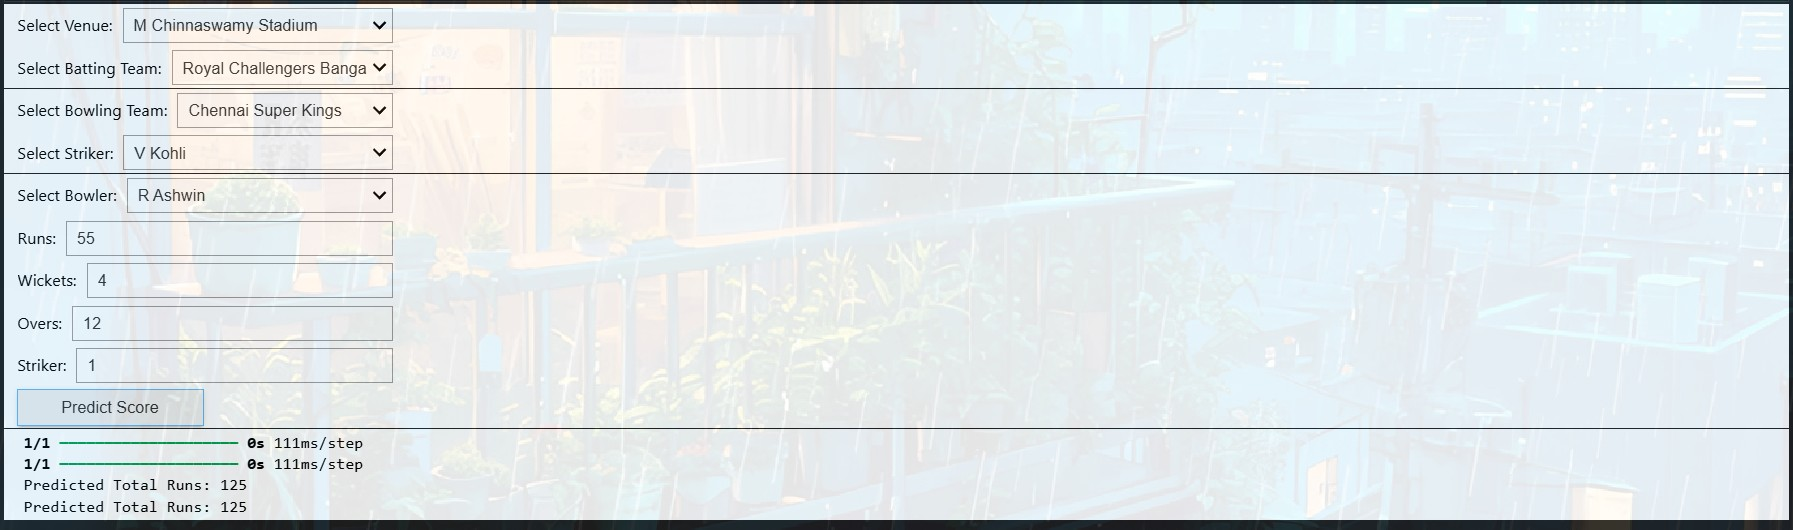

We have predicted the score of the match between RCB and CSK in Chinnaswamy Cricket Stadium. The predicted score of the match is 125.